In [ ]:
import numpy as np
from lucifex.fdm import FE, CN
from lucifex.sim import integrate
from lucifex.viz import plot_mesh, plot_colormap
from lucifex.utils import triangulation, fem_function_components

from py.navier_stokes import navier_stokes_obstacle

Lx = 2.0
Ly = 1.0
r = Ly / 5
c = (0.5 * Lx, 0.5 * Ly)
dx = 0.05
dt_max = 0.5
dt_min = 0.0
cfl_courant = 1.0
rho = 1.0
mu = 1.0
p_in = 8.0
scheme = 'ipcs'
Dadv = FE
Dvisc = CN
simulation = navier_stokes_obstacle(
    Lx,
    Ly,
    r, 
    c,
    dx,
    dt_max,
    dt_min,
    cfl_courant,
    rho,
    mu,
    p_in,
    scheme,
    Dadv,
    Dvisc,
)

n_stop = 50
dt_init = 1e-6
n_init = 5
integrate(simulation, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

In [2]:
u, p = simulation['u', 'p']
mesh = u.function_space.mesh

time_index = -1
un = u.series[time_index]
pn = p.series[time_index]

ux, uy = fem_function_components(('P', 1), un, names=('ux', 'uy'))

In [4]:
simulation.solvers[1]._bcs

In [3]:
mesh_tri = triangulation(mesh)
pn_tri = triangulation(pn)
ux_tri = triangulation(ux)
uy_tri = triangulation(uy)

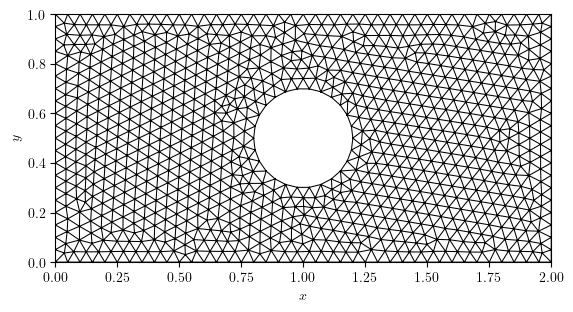

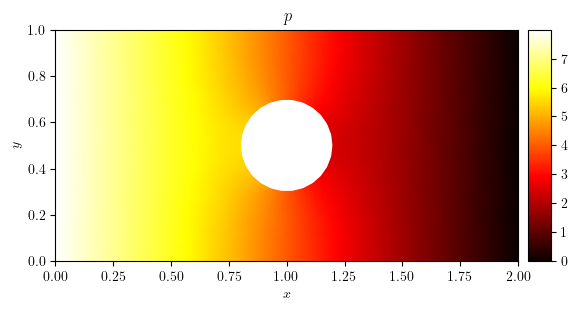

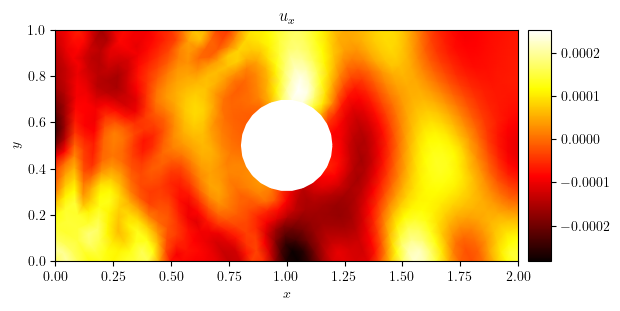

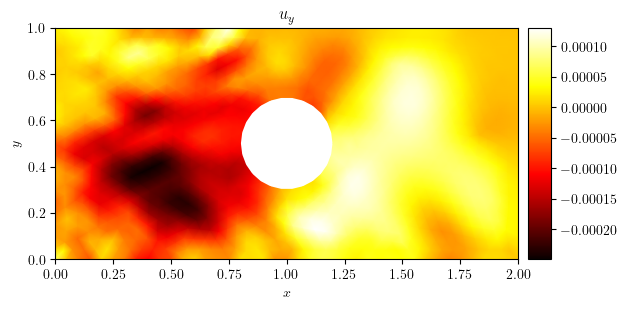

In [4]:
plot_mesh(mesh)

fig, ax = plot_colormap((mesh_tri, pn_tri), title='$p$')

fig, ax = plot_colormap((mesh_tri, ux_tri), title='$u_x$')

fig, ax = plot_colormap((mesh_tri, uy_tri), title='$u_y$')

# Navier-Stokes flow

initial value problem on $(\textbf{x}, t)\in\Omega\times[0,\infty)$

$$\rho \left(\frac{\partial\textbf{u}}{\partial t}+\textbf{u}\cdot\nabla\textbf{u}\right)=\nabla\cdot\sigma + \textbf{f}(\textbf{x}, t)$$

$$\nabla\cdot\textbf{u}=0$$

constitutive relations

$$\varepsilon(\textbf{u})=\tfrac{1}{2}(\nabla\textbf{u} + (\nabla\textbf{u})^{\mathsf{T}})$$

$$\sigma(\textbf{u}, p) = -p\,\mathsf{I} + 2\mu\varepsilon(\textbf{u})$$

$$\implies \nabla\cdot\sigma=-\nabla p + \mu\nabla^2\textbf{u}$$

initial conditions

$$\textbf{u}(\textbf{x},t=0)=\textbf{u}_0(\textbf{x})$$

$$p(\textbf{x},t=0)=p_0(\textbf{x})$$

essential boundary condition on $\textbf{x}\in\partial\Omega_{\text{E}}$

$$\textbf{u}=\textbf{u}_{\text{E}}$$

natural boundary condition on $\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{E}}$

$$\textbf{n}\cdot\sigma = \sigma_{\text{N}}$$

CFL timestep

$$\Delta t^n = \min(\Delta t_{\text{max}}, \Delta t_{\text{CFL}}(\textbf{u}^n))$$

## Incremental pressure correction scheme (IPCS)

$$\rho \frac{\widetilde{\textbf{u}}^{n+1}- \textbf{u}^n}{\Delta t^n}+\rho \mathcal{D}_{\textbf{u}}(\textbf{u}\cdot\nabla\textbf{u})=\nabla\cdot\sigma(\mathcal{D}_\sigma(\textbf{u}), p^n) + \mathcal{D}_{\textbf{f}}(\textbf{f})$$

$$-\rho\frac{\nabla\cdot\widetilde{\textbf{u}}^{n+1}}{\Delta t^n}=\nabla^2 p^n - \nabla^2p^{n+1}$$

$$\rho\frac{\textbf{u}^{n+1}-\widetilde{\textbf{u}}^{n+1}}{\Delta t^n}=\nabla p^n - \nabla p^{n+1}$$

$$\mathcal{D}_{\textbf{u}}=\text{FE}~,~\mathcal{D}_{\sigma}=\text{CN}~,~\mathcal{D}_{\textbf{f}}=\text{BE}$$

variational formulation $\forall(\textbf{v}, q)\in V_{\textbf{u}} \times V_p$

$$F_1(\widetilde{\textbf{u}}^{n+1}, \textbf{v}) = \int_\Omega\text{d}\Omega~\rho \textbf{v}\cdot\frac{\widetilde{\textbf{u}}^{n+1}-\textbf{u}^n}{\Delta t^n} + \rho \textbf{v}\cdot\mathcal{D}_{\textbf{u}}(\textbf{u}\cdot\nabla\textbf{u}) + \varepsilon(\textbf{v})\cdot\sigma(\mathcal{D}_\sigma(\textbf{u}), p^n) -\textbf{v}\cdot\mathcal{D}_{\textbf{f}}(\textbf{f}) -\int_{\partial\Omega}\textbf{v}\cdot(\textbf{n}\cdot\sigma(\mathcal{D}_\sigma(\textbf{u}), p^n))$$

$$F_2(p^{n+1}, q) = \int_\Omega\text{d}\Omega~\nabla q\cdot\nabla p^{n+1} - \nabla q\cdot\nabla p^n + q\rho\frac{\nabla\cdot\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} $$

$$F_3(u^{n+1}, \textbf{v}) = \int_\Omega\text{d}\Omega~\textbf{v}\cdot\rho\frac{\textbf{u}^{n+1}-\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} + \textbf{v}\cdot\nabla p^{n+1} - \textbf{v}\cdot\nabla p^n$$

## Chorin's scheme

$$\rho \frac{\widetilde{\textbf{u}}^{n+1}-\rho \textbf{u}^n}{\Delta t^n}+\mathcal{D}_{\textbf{u}}(\textbf{u}\cdot\nabla\textbf{u})= \mu\nabla^2\mathcal{D}_\sigma(\textbf{u}) + \mathcal{D}_{\textbf{f}}(\textbf{f})$$

$$\rho\frac{\nabla\cdot\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} = \nabla^2p^{n+1}$$

$$\rho\frac{\textbf{u}^{n+1}-\widetilde{\textbf{u}}^{n+1}}{\Delta t^n}= - \nabla p^{n+1}$$

$$\mathcal{D}_{\textbf{u}}=\text{FE}~,~\mathcal{D}_{\sigma}=\text{FE}~,~\mathcal{D}_{\textbf{f}}=\text{BE}$$

variational formulation $\forall(\textbf{v}, q)\in V_{\textbf{u}} \times V_p$

$$F_1(\widetilde{\textbf{u}}^{n+1}, \textbf{v}) = \int_\Omega\text{d}\Omega~\textbf{v}\cdot\frac{\widetilde{\textbf{u}}^{n+1}-\textbf{u}^n}{\Delta t^n} + \textbf{v}\cdot\mathcal{D}_{\textbf{u}}(\textbf{u}\cdot\nabla\textbf{u}) + \mu\nabla\textbf{v}\cdot\nabla\mathcal{D}_{\sigma}(\textbf{u}) -\textbf{v}\cdot\mathcal{D}_{\textbf{f}}(\textbf{f})$$

$$F_2(p^{n+1}, q) = \int_\Omega\text{d}\Omega~\nabla q\cdot\nabla p^{n+1} + \rho q\frac{\nabla\cdot\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} $$

$$F_3(u^{n+1}, \textbf{v}) = \int_\Omega\text{d}\Omega~\textbf{v}\cdot\rho\frac{\textbf{u}^{n+1}-\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} + \textbf{v}\cdot\nabla p^{n+1}$$

<!-- # Navier-Stokes flow

initial value problem on $(\textbf{x}, t)\in\Omega\times[0,\infty)$

$$\rho  \left(\frac{\partial\textbf{u}}{\partial t}+\textbf{u}\cdot\nabla\textbf{u}\right)=\nabla\cdot\sigma + \textbf{f}(\textbf{x}, t)$$

$$\nabla\cdot\textbf{u}=0$$

constitutive relations

$$\varepsilon(\textbf{u})=\tfrac{1}{2}(\nabla\textbf{u} + (\nabla\textbf{u})^{\mathsf{T}})$$

$$\sigma(\textbf{u}, p) = -p\,\mathsf{I} + 2\mu\varepsilon(\textbf{u})$$

$$\implies \nabla\cdot\sigma=-\nabla p + \mu\nabla^2\textbf{u}$$

initial conditions

$$\textbf{u}(\textbf{x},t=0)=\textbf{u}_0(\textbf{x})$$

$$p(\textbf{x},t=0)=p_0(\textbf{x})$$

essential boundary condition on $\textbf{x}\in\partial\Omega_{\text{E}}$

$$\textbf{u}=\textbf{u}_{\text{E}}$$

natural boundary condition on $\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{E}}$

$$\textbf{n}\cdot\sigma = \sigma_{\text{N}}$$

CFL timestep

$$\Delta t^n = \min(\Delta t_{\text{max}}, \Delta t_{\text{CFL}}(\textbf{u}^n))$$

## Incremental pressure correction scheme (IPCS)

$$\rho  \frac{\widetilde{\textbf{u}}^{n+1}-\textbf{u}^n}{\Delta t^n}+\rho  \mathcal{D}_{\textbf{u}}(\textbf{u}\cdot\nabla\textbf{u})=\nabla\cdot\sigma(\mathcal{D}_\sigma(\textbf{u}), p^n) + \mathcal{D}_{\textbf{f}}(\textbf{f})$$

$$-\rho\frac{\nabla\cdot\widetilde{\textbf{u}}^{n+1}}{\Delta t^n}=\nabla^2 p^n - \nabla^2p^{n+1}$$

$$\rho\frac{\textbf{u}^{n+1}-\widetilde{\textbf{u}}^{n+1}}{\Delta t^n}=\nabla p^n - \nabla p^{n+1}$$

$$\mathcal{D}_{\textbf{u}}=\text{FE}~,~\mathcal{D}_{\sigma}=\text{CN}~,~\mathcal{D}_{\textbf{f}}=\text{BE}$$

variational formulation $\forall(\textbf{v}, q)\in V_{\textbf{u}} \times V_p$

$$F_1(\widetilde{\textbf{u}}^{n+1}, \textbf{v}) = \int_\Omega\text{d}\Omega~\rho  \textbf{v}\cdot\frac{\widetilde{\textbf{u}}^{n+1}-\textbf{u}^n}{\Delta t^n} + \rho  \textbf{v}\cdot\mathcal{D}_{\textbf{u}}(\textbf{u}\cdot\nabla\textbf{u}) + \varepsilon(\textbf{v})\cdot\sigma(\mathcal{D}_\sigma(\textbf{u}), p^n) -\textbf{v}\cdot\mathcal{D}_{\textbf{f}}(\textbf{f}) -\int_{\partial\Omega}\textbf{v}\cdot(\textbf{n}\cdot\sigma(\mathcal{D}_\sigma(\textbf{u}), p^n))$$

$$F_2(p^{n+1}, q) = \int_\Omega\text{d}\Omega~\nabla q\cdot\nabla p^{n+1} - \nabla q\cdot\nabla p^n + q\rho\frac{\nabla\cdot\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} $$

$$F_3(u^{n+1}, \textbf{v}) = \int_\Omega\text{d}\Omega~\textbf{v}\cdot\rho\frac{\textbf{u}^{n+1}-\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} + \textbf{v}\cdot\nabla p^{n+1} - \textbf{v}\cdot\nabla p^n$$

## Chorin's scheme

$$\rho  \frac{\widetilde{\textbf{u}}^{n+1}-\rho  \textbf{u}^n}{\Delta t^n}+\mathcal{D}_{\textbf{u}}(\textbf{u}\cdot\nabla\textbf{u})= \mu\nabla^2\mathcal{D}_\sigma(\textbf{u}) + \mathcal{D}_{\textbf{f}}(\textbf{f})$$

$$\rho\frac{\nabla\cdot\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} = \nabla^2p^{n+1}$$

$$\rho\frac{\textbf{u}^{n+1}-\widetilde{\textbf{u}}^{n+1}}{\Delta t^n}= - \nabla p^{n+1}$$

$$\mathcal{D}_{\textbf{u}}=\text{FE}~,~\mathcal{D}_{\sigma}=\text{FE}~,~\mathcal{D}_{\textbf{f}}=\text{BE}$$

variational formulation $\forall(\textbf{v}, q)\in V_{\textbf{u}} \times V_p$

$$F_1(\widetilde{\textbf{u}}^{n+1}, \textbf{v}) = \int_\Omega\text{d}\Omega~\textbf{v}\cdot\frac{\widetilde{\textbf{u}}^{n+1}-\textbf{u}^n}{\Delta t^n} + \textbf{v}\cdot\mathcal{D}_{\textbf{u}}(\textbf{u}\cdot\nabla\textbf{u}) + \mu\nabla\textbf{v}\cdot\nabla\mathcal{D}_{\sigma}(\textbf{u}) -\textbf{v}\cdot\mathcal{D}_{\textbf{f}}(\textbf{f})$$

$$F_2(p^{n+1}, q) = \int_\Omega\text{d}\Omega~\nabla q\cdot\nabla p^{n+1} + \rho q\frac{\nabla\cdot\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} $$

$$F_3(u^{n+1}, \textbf{v}) = \int_\Omega\text{d}\Omega~\textbf{v}\cdot\rho\frac{\textbf{u}^{n+1}-\widetilde{\textbf{u}}^{n+1}}{\Delta t^n} + \textbf{v}\cdot\nabla p^{n+1}$$ -->

## Example: $d=2$ flow past a circle